# SC42150 - Statistical Signal Analysis
## Python Assignment II: Denoising with an FIR filter.


#### Team members
- Laurens Hoogenboom  (4609638):
- Willem van der Linden (4902815):
---


## Introduction

You have recently gotten involved in amateur RF communication, and you have finally managed to trasnmit a signal wirelessly! Your setup constists of one broadcasting antenna and three receiving ones, placed at different distances from the emitter, specifically 5cm, 100cm, and 200cm. The signal you sent was a short recording of a piano note. Upon receiving it however, you realise that it has been corrupted by noise. So now you want to apply what you have learned in the Statistical Signal Analysis course and try to remove the noise. Since the nature of the interference is stochastic, you want to subtract the effects of the distortion by using the theory of Wiener filters.

In the configuration of the figure below, all signals are discrete-time and real.
The corrupted signal $x(n) = d(n) + v(n)$ contains both the signal of interest $d(n)$ and a noise $v(n)$ which is _uncorrelated_ to d(n).
In this assignment you will design a FIR filter $W(z)$, such that we can estimate the ground truth signal from $x(n)$ and from the statistical properties of the noise.

![alt text][anc]

[anc]: ./denoising-scheme.JPG

## Reporting

The report of this python exercise consists of this Jupyter Notebook file, with your answers added after each question. Answers will consist of code and/or text (markdown) cells. Please use the already indicated cells and format. You will **also** need to deliver a `PDF` version of this file.

In order to create a PDF version of this file, go to the top left, click on `File` then `Export Notebook As` and Choose `PDF`.
If this feature is not supported by your system, you can also choose `LaTeX`.
Then, you can use your preferred `LaTeX` compiler to create the `PDF`. After generation you PDF report, please double check if all answers/plots are correctly displayed.

Moreover, you will also need to send the `.mat` files with the signals used in this exercise. Don't forget to edit your team member's name and student number above. You will submit one Jupyter notebook per team.

### Loading files

As mentioned before, you have three recordings available in the form of `piano_xxx.mat` files, one for each receiver distance (5cm, 100cm, 200cm). Furthermore, you have obtained a recording of the passive noise present in the system (`noise.mat`). Run this section in order to load the `.mat` files with the noise audios and the background noise signals.

In [1]:
# packages
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.linalg as lin
import scipy.signal as sig

# use this function to play the signals
# be careful when using headphones!
def play_signal( signal ):
    sd.play( signal.astype('int16'), 22050 )

# modeling distance in centimeters (cm)
distances = np.array( [5.0, 100.0, 200.0] )

# number of experiments with different distances
N_exp = distances.shape[0]

print( f'Number of experiments = {N_exp}' )

# list of files for all distance experiments with audio
filenames = ['piano_5cm.mat', 'piano_100cm.mat', 'piano_200cm.mat']

# Number of data points
N = len( sio.loadmat( filenames[0] )['audio'][0] )

# create array with received data
data_noised = np.zeros( (N_exp, N), dtype=float )
for iexp in range(N_exp):
    data_noised[iexp] = sio.loadmat( filenames[iexp] )['audio'][0]

# array for the time steps
time_steps = np.linspace( 0, N-1, N ).astype( int )
print( f'Number of recording time steps = {N}' )

# load background noise signal that was measured

filename_noise = 'noise.mat'
data_mat = sio.loadmat( filename_noise )['audio'][0]

Nnoise = len( data_mat )
noise_measured = np.array( data_mat, dtype=float)

print( f'Number of noise time steps = {Nnoise}' )

Number of experiments = 3
Number of recording time steps = 65411
Number of noise time steps = 88200


# Exercises
This part should be handled after all audio files were uploaded into `data_noised` array and the noise was uploaded into `noise_measured` file.

## Question 1

Formulate the denoising problem as a Minimum Variance FIR Wiener Problem, using the symbols $x(n)$, $v(n)$, $d(n)$, $\hat{d}(n)$, $e(n)$ as in the figure presented in the **Introduction**.
No numerical values are required, but you need to specify the meaning of all the symbols and their relation to the sent and received data.


### Answer (2 points)
$d(n)$ is the original signal

$v(n)$ is the noise that is applied or added to the signal

$x(n)$ is the signal including the noise

$\hat{d}(n)$ is the filtered/ denoised signal

$e(n)$ is the error between the orignal signal and the denoised signal

$e(n)=d(n)-\hat{d}(n)$

$\hat{d}(n)=x(n)*w(n)$

$x(n)=d(n)+v(n)$

_(where "*" indicates convolution)_



## Question 2

Plot the graphs for the received audio signals and the received noise signal.
Use a separate plot for the noise signal.

### Answer (1 point)


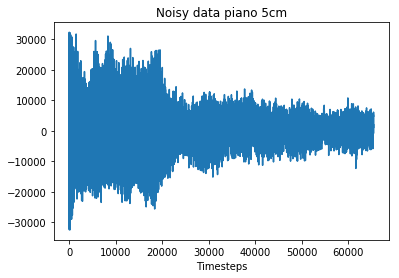

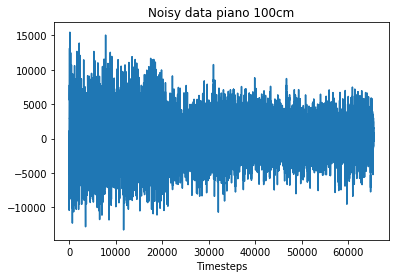

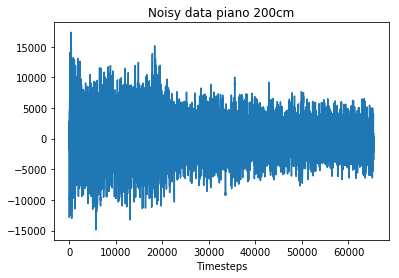

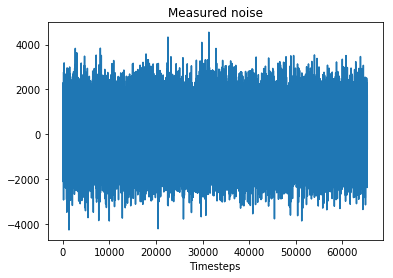

In [23]:
for i in range(3):
    plt.plot(time_steps,data_noised[i])
    plt.xlabel("Timesteps")
    plt.title("Noisy data "+ filenames[i].replace('.mat','').replace('_',' '))
    plt.show()

plt.plot(time_steps,noise_measured[0:len(time_steps)]) #Note, only plots noise for relevant length (timesteps) actual noise measurements is longer
plt.xlabel("Timesteps")
plt.title("Measured noise")
plt.show()

## Question 3

Determine the Wiener-Hopf equation for the denoising case with filter order $m$.
What assumptions are we making for the audio signal and the noise in order to obtain the values of the filter $w$?
Derive how can we calculate the right hand side of the Wiener-Hopf equation assuming that we know $r_x(k), \; \forall k$ 
and the noise variance $\sigma^2_v$.

### Answer (2 points)
The filter designed wil be non-causal. Which was to be expected since the denoising is done in post-processing. Since we are working with audio signal without impedances we assume every signal to be real and complex conjugates are thus irrelevant. Besides that the signals will be assumed to WSS, meaning their mean and variance will be constant over time.

this implies:
$$m_x(n) = m_x<\infty$$
$$\sigma^2_x (n)<\infty$$

$$m_v(n) = m_v<\infty$$
$$\sigma^2_v (0)<\infty$$

$$r_{xx}(k,l) = r_{xx}(k-l), \hspace{3mm} \forall (k,l)$$
$$r_{vv}(k,l) = r_{vv}(k-l), \hspace{3mm} \forall (k,l)$$

This means that the correlations are only dependant on the lags and the place in time that lag is relative to is irrelevant. (i.e. We can denote the correlations as functions of lag k.) The wiener coefficients can be determined using: $R_{xx}\hat{w}=r_{dx}$.

In this equation the lag index in not required because these are vector equations with the correlation coefficients as indices. i.e.:

$$r_{vx} = \begin{bmatrix} r_{vx}(0) \\ r_{vx}(1) \\ \vdots \\ r_{vx}(O_w) \end{bmatrix}$$

$$\hat{w} = \begin{bmatrix} \hat{w}(0) \\ \hat{w}(1) \\ \vdots \\ \hat{w}(O_w) \end{bmatrix}$$

Where $O_w$ is the wiener filter order, which corresponds to the maximum lag in our system of equations. Notice that the R_{xx} matrix has become a topelitz matrix on dimension $O_wxO_w$:

$$\hat{w} = \begin{bmatrix} r_{xx}(0) & r_{xx}(1) & \dots & r_{xx}(O_w) \\ r_{xx}^*(1) & r_{xx}(0) & \dots & r_{xx}(O_w-1) \\ \vdots & \vdots & \ddots & \vdots \\ r_{xx}^*(O_w) & r_{xx}^*(O_w-1) & \dots & r_{xx}(0)\end{bmatrix}$$

As previously concluded, the complex conjugates are irrelevant in real signals and can thus be ignored. We can now rewrite the relation between $R_{xx}$ and $r_{vx}$ as:

$$\hat{w}=R_{xx}^{-1}r_{vx}$$

This gives us our $O_w$ amount of Wiener filter coefficients, which we can use in convolution with out noisy signal to filter it. This will result in an estimate of the noiseless signal. A perfect filter would output a signal that is audibly indistinguishable from the pure signal and the error estimate $e(n)$ would be perfect noise.

## Question 4

Using your background noise measurement, estimate its mean and variance ($\sigma^2_v$). Print these estimates.

In [3]:
#play_signal(data_mat) #uncomment for audio playback
noiseMean = np.mean(noise_measured)
print(f"The mean of the noise signal is: {noiseMean}")
zeroMeanNoise = noise_measured-noiseMean
noiseVar = np.var(zeroMeanNoise)
print(f"the variance of the zero-mean noise is: {noiseVar}")

The mean of the noise signal is: -0.7130270818895483
the variance of the zero-mean noise is: 993764.5058174969


### Answer (1 point)


## Question 5

1. Assuming the ergodicity property of the  audio signals, calculate the auto-correlation function $r_x(k)$ of every received audio signal for lags $0,\dots,9$. Print these values.

2. Calculate the cross-correlation function $r_{dx}(k)$ of every received audio signal for lags $0,\dots,9$. Print these values.

3. Using the auto-correlation estimation formula of the measured noise, compute and plot the noise auto-correlation function for lags $0..9$. Is it ZMWN? Explain your answer.

**Note:** if the signal $x(n)$ is auto-correlation ergodic,
the auto-correlation function $r_x(k)$ can be estimated as
(if we have only values $x_1, x_2, \dots, x_N$):
$$
    r_x(k) = \frac{1}{N-k} \sum_{i=k+1}^{N} x(i) x^*(i-k)
$$

**Note:** if you are unfamiliar with python, take care when copying `np.arrays`. Read more [here](https://numpy.org/doc/stable/reference/generated/numpy.copy.html).

### Answer (3 points)


In [62]:
# length of data noised was used instead of data measured because of them being inequal lengths. meaning the shortest has to be used.
N=len(data_noised[0])
x = data_noised[0]
v = noise_measured

def getCorr(data,N):
    rxx = np.zeros(10)
    rvx = np.zeros(10)
    rvv = np.zeros(10)
    for r in range(0,10):
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for k in range(0,N-r):
            sum1 += x[k+r]*x[k]
            sum2 += v[k+r]*x[k]
            sum3 += v[k+r]*v[k]

        rxx[r] = sum1/(N-r)
        rvx[r] = sum2/(N-r)
        rvv[r] = sum3/(N-r)
    return rxx,rvx,rvv
# for i in range(0,10):
#     print("The autocorrelation of the received signal with lag %d is %.2f" % (i,rxx[i]))
#     print("The crosscorrelation of the received signal and the noise with lag %d is %.2f" % (i,rvx[i]))
#     print("The autocorrelation of the noise with lag %d is %.2f" % (i,rvx[i]))
for i in range(3):
    [rxx,rvx,rvv] = getCorr(data_noised[i],N)
    print("The autocoralation of",filenames[i].replace('.mat','').replace('_',' '),"audio for a lag of 0...9 is",*np.round(rxx,2),"respectivly")
    print("The crosscorrelation of the noise and the'",filenames[i].replace('.mat','').replace('_',' '),"audio for a lag of 0...9 is",*np.round(rvx,2),"respectivly")
    print("\n")
print("The autocorrelation of the recorded noise for a lag of 0 ...9 is",*np.round(rvv,2),"respectivly")

The autocoralation of piano 5cm audio for a lag of 0...9 is 42539267.27 41425877.28 40271794.86 38773396.27 36800737.67 34672741.23 32451796.98 30227588.11 28041970.6 25931901.29 respectivly
The crosscorrelation of the noise and the' piano 5cm audio for a lag of 0...9 is 7090.09 15491.56 10038.01 18809.95 23111.86 18752.98 21260.23 17097.59 22033.68 19393.8 respectivly


The autocoralation of piano 100cm audio for a lag of 0...9 is 42539267.27 41425877.28 40271794.86 38773396.27 36800737.67 34672741.23 32451796.98 30227588.11 28041970.6 25931901.29 respectivly
The crosscorrelation of the noise and the' piano 100cm audio for a lag of 0...9 is 7090.09 15491.56 10038.01 18809.95 23111.86 18752.98 21260.23 17097.59 22033.68 19393.8 respectivly


The autocoralation of piano 200cm audio for a lag of 0...9 is 42539267.27 41425877.28 40271794.86 38773396.27 36800737.67 34672741.23 32451796.98 30227588.11 28041970.6 25931901.29 respectivly
The crosscorrelation of the noise and the' piano 200cm 

## Question 6

Using a 10-th order FIR Wiener filter, calculate the optimal filter coefficients for every received audio signal. Print these values.

**Note:** The `scipy.linalg.toeplitz()` function may be useful.

### Answer (2 points)


In [69]:
for i in range(3):
    [rxx,rvx,rvv] = getCorr(data_noised[i],N)
    Rxx = lin.toeplitz(rxx)
    Rvx = np.transpose(rvx)
    W = abs(np.matmul(lin.inv(Rxx),Rvx))
    print("The 10-th order Wienerfilter for the",filenames[i].replace('.mat','').replace('_',' '),"audio has the following coefficients:\n",*np.round(W,5),'\n')

The 10-th order Wienerfilter for the piano 5cm audio has the following coefficients:
 0.00277 0.00528 0.00621 0.00198 0.00441 0.0024 0.00183 0.00461 0.00334 0.00051 

The 10-th order Wienerfilter for the piano 100cm audio has the following coefficients:
 0.00277 0.00528 0.00621 0.00198 0.00441 0.0024 0.00183 0.00461 0.00334 0.00051 

The 10-th order Wienerfilter for the piano 200cm audio has the following coefficients:
 0.00277 0.00528 0.00621 0.00198 0.00441 0.0024 0.00183 0.00461 0.00334 0.00051 



## Question 7

Using the computed filter coefficients, compute an estimate of the denoised audio signals from the received ones.
Plot together the denoised signal with the originally received one. Draw one plot for every audio signal.

Use the example code from this jupyter notebook (`play_signal()` function) in order to play the denoised signals - do you hear the difference between the originally received and the denoised one? 

**Note:** the `scipy.signal.lfilter()` function can be useful when using the Wiener filter.

### Answer (3 points)


The acchieved signals are not quite perfect. They sound muffled and the noise is still significantly present. However, we would say that the piano tone is more dominant over the noise now than it was, meaning there is some succes here.

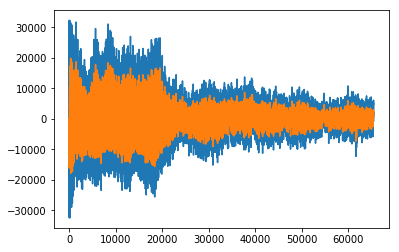

In [6]:
# Manual convolution resulted in an audibly better result in this case, so we went with that instead
out = np.zeros(N)
for n in range(0,N): #manual convolution
    for l in range(0,10):
        if n-l>=0:
            out[n] += 20* abs(W[l])*x[n-l] # x20 amp for better playback vollume 

#play_signal(data_noised[0])
play_signal(out)


plt.plot(time_steps,data_noised[0])
plt.plot(time_steps,out)
plt.show()

## Question 8

Now we will attempt to understand what the Wiener filter is doing. To that end we will use the periodogram on the noisy and filtered signals. Calculate $P_x$ and $P_{\hat d}$ for each recording. For each distance, create two side-by-side plots: the first subplot should show $P_x$ and $P_{\hat d}$ over the whole positive discrete frequency spectrum $[0, \pi]$ rad/sample, while the second subplot should show the exact same graph but zoomed in on the lower frequencies, e.g. $[0,0.8]$ rad/sample. The $y$-axis should be in decibels, i.e. $20 \log_{10} P$. What do you conclude?

**Note:** Plot first $P_x$ and then overlay on top $P_{\hat d}$. Also play with transparencies to achieve a readable plot. In order to avoid indexing mistakes, it's suggested to use the `numpy.fft.fftfreq` function.

          


### Answer (2 points)


## Question 9

To further investigate what the Wiener filter is doing, we will plot its frequency response. In a single plot the frequency response for each Wiener filter over the positive discrete frequency spectrum. Make sure the $y$-axis is in decibels. What do you conclude?        


### Answer (2 points)


## Question 10 (bonus)

Do you think you can change something to achieve better results than the above (by using this setup)? If so, how? If not, elaborate.

### Answer (2 bonus points)
